## Временные ряды. Построение и оценка модели

Содержание:
* [Time Series "Потребление энергии"](#ts)
* [Генерация новых признаков (недельный ресемплинг)](#gen)
* [Выделение значимых признаков](#srchf)
* [Train test splitting](#ttspl)
* [Построение моделей](#modelbulding)
* [Сохраниение моделей](#modelsaving)
* [Использование моделей для предсказания n\*h моментов времени](#modelpred)

## Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

## Time Series "Потребление энергии"
<left><a class="anchor" id="ts"></a><left>
Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption ). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import warnings
from random import random
import itertools
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
import pickle

from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

In [5]:
# Ресемплинг данных

data_d = data.copy().resample('D').mean()
data_m = data.resample('M').mean()
data_w = data.resample('W').mean()
data_Y = data.resample('3M').mean()

Общий вид изменения потребления энергии по различным периодам усреднения

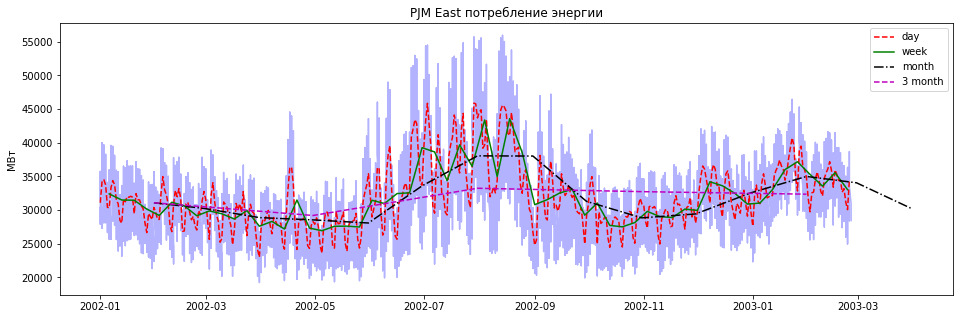

In [6]:
# Визуализация полученных семплов

plt.figure(figsize =(16,5))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

## Генерация новых признаков (недельный ресемплинг)
<left><a class="anchor" id="gen"></a><left>

In [7]:
data_w.head(3)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.0,3.517483,1.0,3.517483,1.0,3.517483,11.58042,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.0,10.000000,1.0,10.000000,2.0,3.000000,11.50000,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.0,17.000000,1.0,17.000000,3.0,3.000000,11.50000,0.000000,0.142857,0.000000


В датасете есть избыточные временные признаки, обработка которых приведет к значительному увеличению базы без особого увеличения информативности:
- видно, что в результате усреднения при ресемплинге некоторые целые значения стали дробными, что в целом искажает представление
- в недельных данных часы не имеют актиальности. Удаляем
- Категорийные признаки ['year','month','dayofmonth','quarter','dayofyear','weekofyear','dayofweek'] не стоит превращать в dummy-переменную, т.к. это приведет к значительному увеличению базы.
- Поскольку в годовом развороте ряда тренда нет (временные ряды 2 и 3), то признак 'year' можно исключить.


In [8]:
data_w.drop([
    'hour','year','month', 'dayofmonth', 'dayofyear',
    'dayofweek', 'is_holiday', 'is_prev_holiday','is_next_holiday'],
    axis=1,inplace=True)

Можно построить интегральный признак используя кластер-анализ или частичную классификацию. Начнем с признака по кластер-анализу. Воспользуемся методом kmeans, если можем предположить сколько будет кластеров, или DBSCAN, который не требует знания реального числа кластеров. 

Число кластеров в календаре с масштабированием:  1
Число кластеров в календаре:  4


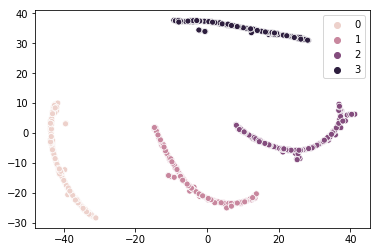

In [9]:
scl=StandardScaler()
tsne_ = TSNE(n_components=2)

X = data_w.iloc[:,:-1].values
Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)

clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)

print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

plt.show()

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.

In [10]:
# Экспоненциальное сглаживание

def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# Производные признаки

def get_deriv_feats(df, colname):
    df[colname + ' (^2)'] = df[colname] ** 2
    df[colname + ' (^3)'] = df[colname] ** 3
    df[colname + ' (sqrt)'] = np.sqrt(df[colname])
    df[colname + ' (log)'] = np.log(df[colname])
    df[colname + ' (/ 2)'] = df[colname] / 2
    df[colname + ' (/ 4)'] = df[colname] / 4
    return df

In [11]:
# Разности
first_diff = np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

first_diff_w =(first_diff) / data_w.iloc[1:,0].values
data_w['diff1_w'] = 0
data_w['diff1_w'] =  data_w['diff1_w'].astype('float') 
data_w['diff1_w'].values[1:] = np.array(first_diff_w).astype('float32')

first_diff_l =np.log(data_w.iloc[1:,0].values) 
data_w['diff1_l'] = 0
data_w['diff1_l'] =  data_w['diff1_l'].astype('float') 
data_w['diff1_l'].values[1:] = first_diff_l

# Кластеры
data_w['MW_quarter'] = X_clast 

# Скользящее среднее (4)
data_w['w_w4']=data_w['PJME_MW'].rolling(window=4).mean() 


# Экспоненциальное сглаживание
data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_04'] = exponential_smoothing(data_w['PJME_MW'], 0.04)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)


# Производные признаки
data_w = get_deriv_feats(data_w, 'PJME_MW')


# PCA 
pca = PCA(n_components=1, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
data_w['pca']=Xpca

# История длиной p в признаках автокорреляции
p = 4
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]

# Первые разности на глубину p
# p = 4
for i in range(p):
    data_w['d'+str(p-i)]=0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]    


feats = data_w.columns # перечень сгенерированных признаков

In [12]:
feats1 = ['PJME_MW', 'w_w4']
feats2 = ['diff1_w', 'diff1_l', 't4', 't3', 't2', 't1', 'd4', 'd3', 'd2', 'd1']
feats3 = ['exp_0_01', 'exp_0_03', 'exp_0_04', 'exp_0_06', 'exp_0_07', 'exp_0_08']
feats4 = ['PJME_MW (sqrt)', 'PJME_MW (/ 2)', 'PJME_MW (/ 4)', 'pca']

f_lst, b_names = [feats1, feats2, feats3, feats4], ['smoothed data', 'differences', 'exponential smoothing', 'derivatives']

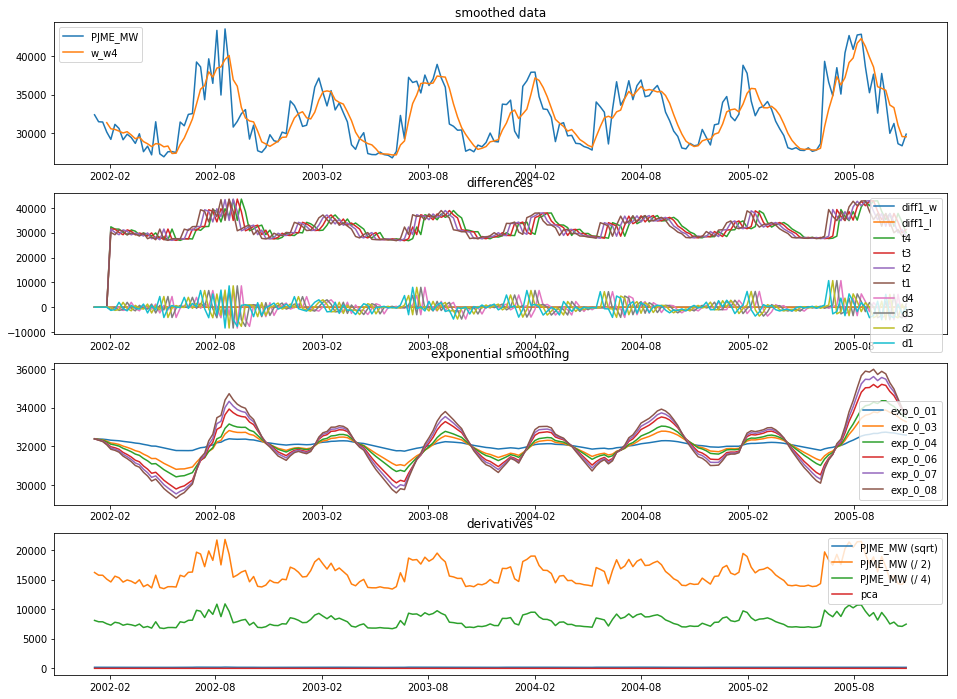

In [13]:
N100 = 200

plt.figure(figsize=(16,12))
for i in range(len(f_lst)):
    plt.subplot(len(f_lst),1,i+1)
    plt.title(b_names[i])
    
    for feature in f_lst[i]:
        
        plt.plot(data_w.index[:N100], data_w[feature][:N100], label = feature)
        plt.legend()
plt.show()

## Выделение существенных признаков
<left><a class="anchor" id="srchf"></a><left>

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [14]:
# Подготовка входного набора данных с учетом горизонта (h) и глубины (p) прогнозирования
def get_scaled_h_data(data, h, p):
    
    scl_x = StandardScaler() # Скалирование признаков (сохраняется для обратного скалирования)
    scl_target = StandardScaler() # Скалирование целевой переменной
    
    X = data.iloc[p:-h,:].values
    X = scl_x.fit_transform(X.astype('float64'))
    
    target = data['PJME_MW'].values[h+p:].reshape((data.shape[0]-h-p,1))
    y = scl_target.fit_transform(target)
    
    return X, y, scl_x, scl_target  

In [15]:
# Получение входного набора данных

h1 = 1
h4 = 4
p = 4

X1, y1, scl_x1, scl_target1 = get_scaled_h_data(data_w, h1, p)
X4, y4, scl_x4, scl_target4 = get_scaled_h_data(data_w, h4, p)

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

Как и во всех задачах обучения, системах признаков не идеальна. Есть признаки хорошие, а есть признаки плохие. Применим механизмы  селекции признаков для нашей модели. 
Рассмотрим механизмы селекции специфичные для регрессий и доступные из scikit-learn. Это два основных способа селекции: 
- построим или применим метрику взвешивающую связь признака и целевого свойства,
- проведем предварительное обучение и проверим влиятельность признаков по результатам такого обучения.

Такое решение задачи селекции признаков поддерживается через SelectKBest (отбираем k лучших признаков), SelectPercentile (отбираем заданный процент признаков) и SelectFromModel, соответственно(https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Посмотрим на результаты оценки нашей системы признаков.

In [16]:
f_test, _ = f_regression(X1, y1.ravel())
f_test /= np.max(f_test)
for i in range(X1.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=0.97,  I=0
F-test=0.00,  I=1
F-test=0.00,  I=2
F-test=0.02,  I=3
F-test=0.01,  I=4
F-test=1.00,  I=5
F-test=0.00,  I=6
F-test=0.58,  I=7
F-test=0.01,  I=8
F-test=0.01,  I=9
F-test=0.02,  I=10
F-test=0.03,  I=11
F-test=0.04,  I=12
F-test=0.05,  I=13
F-test=0.92,  I=14
F-test=0.84,  I=15
F-test=0.99,  I=16
F-test=1.00,  I=17
F-test=0.97,  I=18
F-test=0.97,  I=19
F-test=0.00,  I=20
F-test=0.07,  I=21
F-test=0.16,  I=22
F-test=0.30,  I=23
F-test=0.51,  I=24
F-test=0.04,  I=25
F-test=0.03,  I=26
F-test=0.02,  I=27
F-test=0.02,  I=28


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]). Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [17]:
# Генерация списка лучших признаков

def get_feature_selections(X, y, best_features_num=6, perc=20, intersects=0):
    
    # SelectKBest (отбираем k лучших признаков)
    sfk = SelectKBest(f_regression, k=best_features_num)
    X_new1 = sfk.fit_transform(X, y.ravel())
    column_names = data_w.columns[sfk.get_support()]
    
    # SelectPercentile (отбираем заданный процент признаков)
    sfp = SelectPercentile(f_regression, percentile=perc)
    X_new2 = sfp.fit_transform(X, y.ravel())
    column_namesp = data_w.columns[sfp.get_support()]
    
    # SelectFromModel
    gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
    sfm = SelectFromModel(gr_model,  max_features = 5)
    sfm.fit(X, y.ravel())
    X_new3 = sfm.transform(X)
    
    list_param_k =np.where(sfk.get_support())[0]
    list_param_p =np.where(sfp.get_support())[0]
    list_param_m =np.where(sfm.get_support())[0]

    print('Номера признаков k лучших признаков : ',list_param_k)
    print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
    print('Номера признаков для выбора по модели : ',list_param_m, '\n')
    
    params_list = [list_param_k, list_param_p, list_param_m]
    params_intersection = list(set(params_list[0]).intersection(*params_list))
    
    lstmerge = lambda ll: [el for lst in ll for el in lst]
    params_unite = set(lstmerge(params_list))
    
    if intersects == 0:
        return list(params_unite)
    elif intersects == 1:
        return params_intersection
    else:
        return None

In [18]:
# ['PJME_MW', 'diff1_l', 'PJME_MW (^3)', 'PJME_MW (sqrt)', 'PJME_MW (log)','PJME_MW (/ 2)', 'PJME_MW (/ 4)']
list_par1 = get_feature_selections(X1, y1, intersects=0)
X1_new = X1[:,list_par1]
target_columns1 = data_w.columns[list_par1] 

# ['PJME_MW', 'weekofyear', 'diff1_l', 'exp_0_08', 'PJME_MW (^3)', 'PJME_MW (sqrt)', 'PJME_MW (log)', 'PJME_MW (/ 2)', 'PJME_MW (/ 4)','t4']
list_par4 = get_feature_selections(X4, y4, intersects=0)
X4_new = X4[:,list_par4]
target_columns4 = data_w.columns[list_par4]

Номера признаков k лучших признаков :  [ 0  5 16 17 18 19]
Номера признаков лучших признаков по процентной форме:  [ 0  5 16 17 18 19]
Номера признаков для выбора по модели :  [ 5 15 16 17 18] 

Номера признаков k лучших признаков :  [ 0  5 16 17 18 19]
Номера признаков лучших признаков по процентной форме:  [ 0  5 16 17 18 19]
Номера признаков для выбора по модели :  [ 2  5 13 15 21] 



## Train test splitting
<left><a class="anchor" id="ttspl"></a><left>


Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [19]:
# Функция для сплиттинга
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

Для временного ряда "Потребление энергии" дата разделения будет соответствовать дате для 85% данных

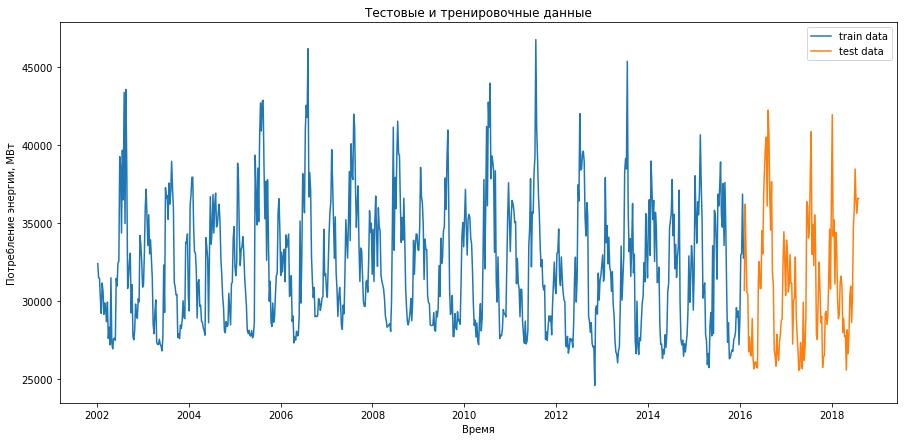

In [20]:
split_rate = 0.15 # Размер тестовой выборки, %

split_date = data.index[(int(len(data.index) * (1-split_rate)))]

train, test = split_data(data_w, split_date)

plt.figure(figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [21]:
# Подготовка тренеровочных и тестовых данных для обеих выборок

X_train_1 = X1_new[:train.shape[0],:]
y_train_1 = y1[:train.shape[0],0]
X_test_1 = X1_new[train.shape[0]:,:]
y_test_1 = y1[train.shape[0]:,0]

X_train_4 = X4_new[:train.shape[0],:]
y_train_4 = y4[:train.shape[0],0]
X_test_4 = X4_new[train.shape[0]:,:]
y_test_4 = y4[train.shape[0]:,0]

## Построение моделей
<left><a class="anchor" id="modelbuilding"></a><left>

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [22]:
# Модель с глубиной предсказания 1
model_1 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_1.fit(X_train_1, y_train_1)
y_test_pred_1 = model_1.predict(X_test_1)

# Модель с глубиной предсказания 4
model_4 = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_4.fit(X_train_4, y_train_4)
y_test_pred_4 = model_4.predict(X_test_4)

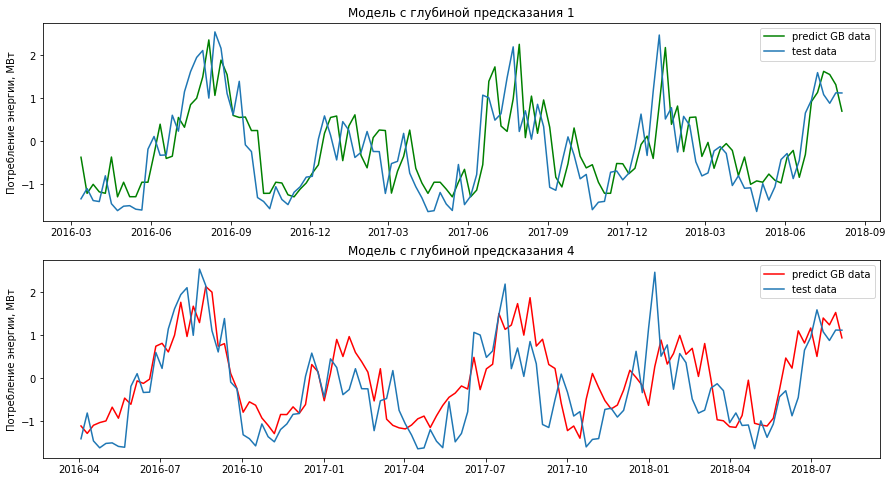

In [23]:
plt.figure(figsize=(15, 8))

plt.subplot(2,1,1)
plt.title('Модель с глубиной предсказания 1')

plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h1+p:],y_test_pred_1,'g', label='predict GB data')
plt.plot(test.index[h1+p:],y_test_1, label='test data')
plt.legend()

plt.subplot(2,1,2)
plt.title('Модель с глубиной предсказания 4')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h4+p:],y_test_pred_4,'r', label='predict GB data' )
plt.plot(test.index[h4+p:],y_test_4, label='test data')
plt.legend()

plt.show()

In [24]:
# Функционал ошибки MAPE

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Вывод метрик качества

def get_errors(y_test, y_test_pred_g, scl_target, h):
    
    er_g = mean_absolute_percentage_error(
    y_true=scl_target.inverse_transform(y_test),
    y_pred = scl_target.inverse_transform( y_test_pred_g)
    )

    er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
    er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
    er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)
    print(f'Модель с глубиной предсказания {h}:\n')
    print('Ошибка MSE :  ', er_s,'\nОшибка MAE  :  ', er_a,'\nОценка R2 :  ', er_r2,'\nОшибка MAPE :', round(er_g,2),'%\n')

In [25]:
get_errors(y_test_1, y_test_pred_1, scl_target1, h1)
get_errors(y_test_4, y_test_pred_4, scl_target4, h4)

Модель с глубиной предсказания 1:

Ошибка MSE :   0.5119331380755583 
Ошибка MAE  :   0.577060931022674 
Оценка R2 :   0.5260416860057531 
Ошибка MAPE : 7.32 %

Модель с глубиной предсказания 4:

Ошибка MSE :   0.554033613387897 
Ошибка MAE  :   0.5946725878238174 
Оценка R2 :   0.48568553338387643 
Ошибка MAPE : 7.74 %



##### Подбор параметров моделей

In [26]:
def report(results, h, n_top=3):
    print(f'{"*"*40} Ranking model with h = {h} {"*"*40}\n\n')
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3,2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr = GradientBoostingRegressor()

# h1
random_search_1 = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)
random_search_1.fit(X_train_1, y_train_1)
report(random_search_1.cv_results_, h1)

# h4
random_search_4 = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)
random_search_4.fit(X_train_4, y_train_4)
report(random_search_4.cv_results_, h4)

**************************************** Ranking model with h = 1 ****************************************


Model with rank: 1
Mean validation score: 0.607 (std: 0.060)
Parameters: {'n_estimators': 200, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.603 (std: 0.061)
Parameters: {'n_estimators': 500, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.592 (std: 0.060)
Parameters: {'n_estimators': 100, 'max_depth': 2}

**************************************** Ranking model with h = 4 ****************************************


Model with rank: 1
Mean validation score: 0.629 (std: 0.074)
Parameters: {'n_estimators': 300, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.627 (std: 0.062)
Parameters: {'n_estimators': 500, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.620 (std: 0.075)
Parameters: {'n_estimators': 400, 'max_depth': 2}



Выбираем модель с рангом 1. {'n_estimators': 100, 'max_depth': 1} для горизонта h1 и {'n_estimators': 200, 'max_depth': 2} для h4 (в одном из запусков RandomizedSearchCV был лучший резльтат) и проведем ее обучение на тренировочном наборе.

In [27]:
model_g_best_1 = GradientBoostingRegressor(max_depth=1,  n_estimators=100)
model_g_best_1.fit(X_train_1, y_train_1) 
y_test_pred_1 = model_g_best_1.predict(X_test_1)

model_g_best_4 = GradientBoostingRegressor(max_depth=2,  n_estimators=200)
model_g_best_4.fit(X_train_4, y_train_4) 
y_test_pred_4 = model_g_best_4.predict(X_test_4)

get_errors(y_test_1, y_test_pred_1, scl_target1, h1)
get_errors(y_test_4, y_test_pred_4, scl_target4, h4)

Модель с глубиной предсказания 1:

Ошибка MSE :   0.419930065133321 
Ошибка MAE  :   0.5204511630008226 
Оценка R2 :   0.6112200385888917 
Ошибка MAPE : 6.65 %

Модель с глубиной предсказания 4:

Ошибка MSE :   0.5562416733452674 
Ошибка MAE  :   0.584054744115498 
Оценка R2 :   0.48363577114600964 
Ошибка MAPE : 7.65 %



Ошибки MAPE для моделей:

h1 снизилась с 7.32 % с до 6.65 %

h4 снизилась с 7.74 % до 7.65%

## Сохраниение моделей
<left><a class="anchor" id="modelsaving"></a><left>

In [28]:
# save the model 1 to disk
filename = 'final_model_h1.sav'
pickle.dump(model_g_best_1, open(filename, 'wb'))

filename = 'final_scaler_y_h1.sav'
pickle.dump(scl_target1, open(filename, 'wb'))

filename = 'final_scaler_x_h1.sav'
pickle.dump(scl_x1, open(filename, 'wb'))


# save the model 4 to disk
filename = 'final_model_h4.sav'
pickle.dump(model_g_best_4, open(filename, 'wb'))

filename = 'final_scaler_y_h4.sav'
pickle.dump(scl_target4, open(filename, 'wb'))

filename = 'final_scaler_x_h4.sav'
pickle.dump(scl_x4, open(filename, 'wb'))

## Использование моделей для предсказания n*h моментов времени
<left><a class="anchor" id="modelpred"></a><left>

Мы построили короткий прогноз, но его можно продолжить на следующие точки ряда. Для этого будем использовать результаты прогноза для следующего шага.  Необходимо заменять X_test[t+i, 0] = y_test[t+i-1] и продолжить моделирование в новом состоянии. Сделаем прогноз на несколько шагов.

In [46]:
target_columns4

Index(['PJME_MW', 'weekofyear', 'diff1_l', 'exp_0_08', 'PJME_MW (^3)',
       'PJME_MW (sqrt)', 'PJME_MW (log)', 'PJME_MW (/ 2)', 'PJME_MW (/ 4)',
       't4'],
      dtype='object')

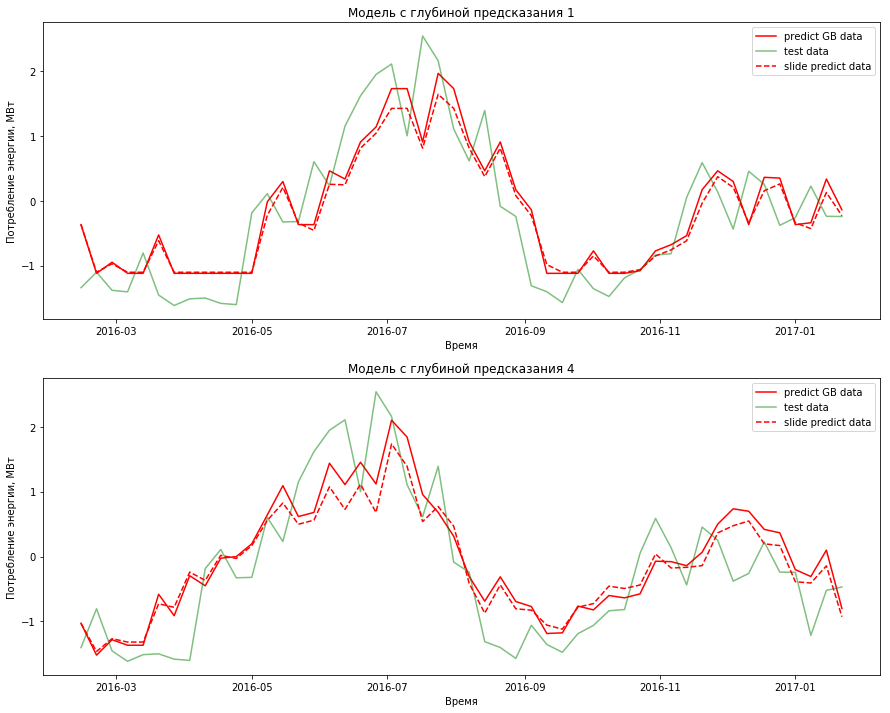

In [80]:
N_steps = 50

X_test_100_1 = X_test_1.copy()
y_test_100_1 = y_test_pred_1.copy()

X_test_100_4 = X_test_4.copy()
y_test_100_4 = y_test_pred_4.copy()


"""h1"""
#'PJME_MW', 'diff1_l', 'PJME_MW (^3)', 'PJME_MW (sqrt)', 'PJME_MW (log)','PJME_MW (/ 2)', 'PJME_MW (/ 4)'

for i in range(N_steps):
    # Предсказываем значения для 1-го шага
    y_test_100_1[i] = model_g_best_1.predict(X_test_100_1[i,:].reshape((1, X_test_100_1.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target1.inverse_transform(y_test_100_1[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100_1[i+1,0] = (y_i-scl_x1.mean_[0])/scl_x1.scale_[0]
    
    
    #строим 'diff1_l' - признак под номером 1
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x1.mean_[15])*scl_x1.scale_[15]
    #устанавливаем новое значение для 1
    X_test_100_1[i+1,1] = xy_i 

"""h4"""
# 'PJME_MW', 'weekofyear', 'diff1_l', 'exp_0_08', 'PJME_MW (^3)',
# 'PJME_MW (sqrt)', 'PJME_MW (log)', 'PJME_MW (/ 2)', 'PJME_MW (/ 4)','t4'

for i in range(N_steps):
    y_test_100_4[i] = model_g_best_4.predict(X_test_100_4[i,:].reshape((1, X_test_100_4.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target4.inverse_transform(y_test_100_4[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100_4[i+1,0] = (y_i-scl_x4.mean_[0])/scl_x4.scale_[0]

    #строим 'diff1_l' - признак под номером 2
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x4.mean_[15])*scl_x4.scale_[15]
    #устанавливаем новое значение для 2
    X_test_100_4[i+1,2] = xy_i 
    
    
plt.figure(figsize=(15, 12))

plt.subplot(2,1,1)
plt.title('Модель с глубиной предсказания 1')

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N_steps+1],y_test_pred_1[:N_steps], 'r',label='predict GB data' )
plt.plot(test.index[1:N_steps+1],y_test_1[:N_steps], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N_steps+1],y_test_100_1[:N_steps], '--r',label='slide predict data')
plt.legend()

plt.subplot(2,1,2)
plt.title('Модель с глубиной предсказания 4')

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N_steps+1],y_test_pred_4[:N_steps], 'r',label='predict GB data' )
plt.plot(test.index[1:N_steps+1],y_test_4[:N_steps], 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N_steps+1],y_test_100_4[:N_steps], '--r',label='slide predict data')
plt.legend()

plt.show()

In [77]:
def count_errors(y_test, y_test_100, scl_target, h, batches=[10,20,30,40,50,60,70,80,90,100], batch_size=10):
    errs = []    
    print(f'\n{"*"*30} Оценка модели с глубиной предсказания h = {h} {"*"*30}\n')
    for batch in batches:

        er_g = mean_absolute_percentage_error(
            y_true=scl_target.inverse_transform(y_test[batch-batch_size:batch]),
            y_pred = scl_target.inverse_transform(y_test_100[batch - batch_size:batch])
        )
        errs.append(er_g)

        print(f'batch #{batch}\nошибка градиентного бустинга MAPE : {round(er_g, 2)} %')
    return errs

In [78]:
errs_1 = count_errors(y_test_1, y_test_100_1, scl_target1, h1)
errs_4 = count_errors(y_test_4, y_test_100_4, scl_target4, h4)


****************************** Оценка модели с глубиной предсказания h = 1 ******************************

batch #10
ошибка градиентного бустинга MAPE : 6.99 %
batch #20
ошибка градиентного бустинга MAPE : 7.06 %
batch #30
ошибка градиентного бустинга MAPE : 8.09 %
batch #40
ошибка градиентного бустинга MAPE : 3.8 %
batch #50
ошибка градиентного бустинга MAPE : 5.14 %
batch #60
ошибка градиентного бустинга MAPE : 7.72 %
batch #70
ошибка градиентного бустинга MAPE : 6.96 %
batch #80
ошибка градиентного бустинга MAPE : 9.75 %
batch #90
ошибка градиентного бустинга MAPE : 6.07 %
batch #100
ошибка градиентного бустинга MAPE : 9.71 %

****************************** Оценка модели с глубиной предсказания h = 4 ******************************

batch #10
ошибка градиентного бустинга MAPE : 7.4 %
batch #20
ошибка градиентного бустинга MAPE : 7.72 %
batch #30
ошибка градиентного бустинга MAPE : 6.01 %
batch #40
ошибка градиентного бустинга MAPE : 5.03 %
batch #50
ошибка градиентного бустинга MAPE

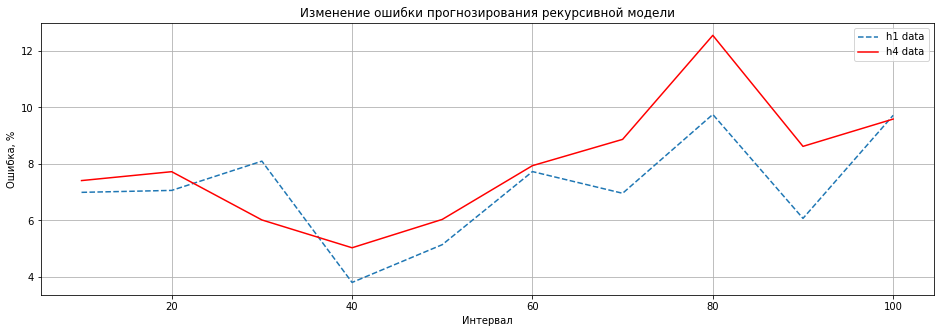

In [79]:
batches= np.arange(10,110, 10)

plt.figure(figsize=(16,5))
plt.title('Изменение ошибки прогнозирования рекурсивной модели')
plt.xlabel('Интервал')
plt.ylabel('Ошибка, %')
plt.plot(batches, errs_1, '--',label='h1 data' )
plt.plot(batches, errs_4, 'r',label='h4 data' )
plt.legend()
plt.grid()
plt.show()

Выводы:

- Временной ряд "Потребление энергии" хорошо подготовлен и имеет ярко выраженные сезонные циклы, что позволило построить эффективные предсказательные модели.  
- Построение новых признаков и их обработка позволяет улучшить качество модели.
- Использование авторекурсивной модели позволяет строить новые прогнозы на основе полученных ранее. При этом, ошибка предыдущих прогнозов может накапливаться, что ограничивает горизонт прогнозирования.
